After masking, 374 valid depths remain.
delta_t (seconds): 585785.537969
After masking, 375 valid depths remain.
delta_t (seconds): 4354502.658953
After masking, 371 valid depths remain.
delta_t (seconds): 480659.626726
After masking, 371 valid depths remain.
delta_t (seconds): 4865427.73531


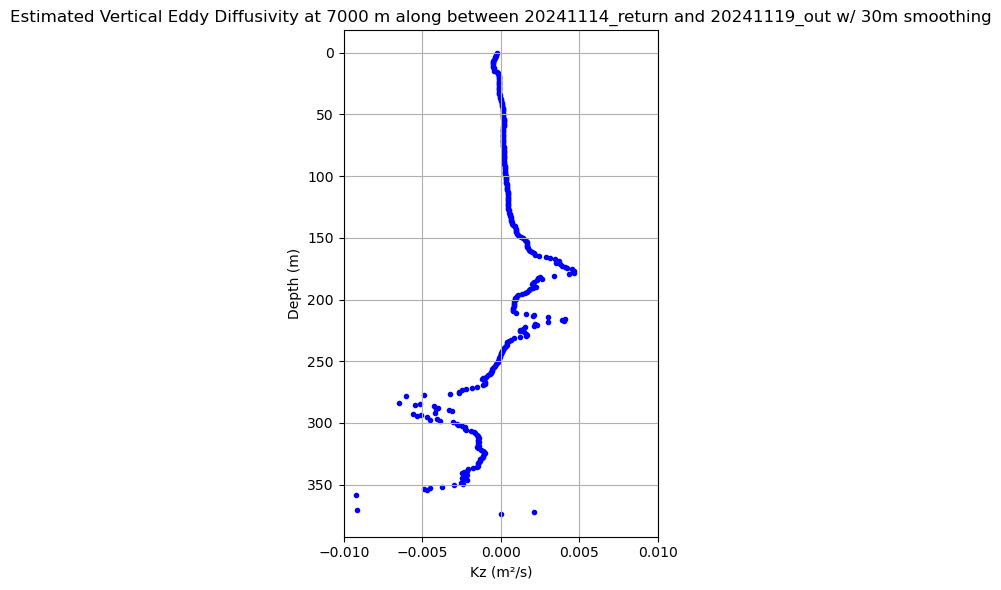

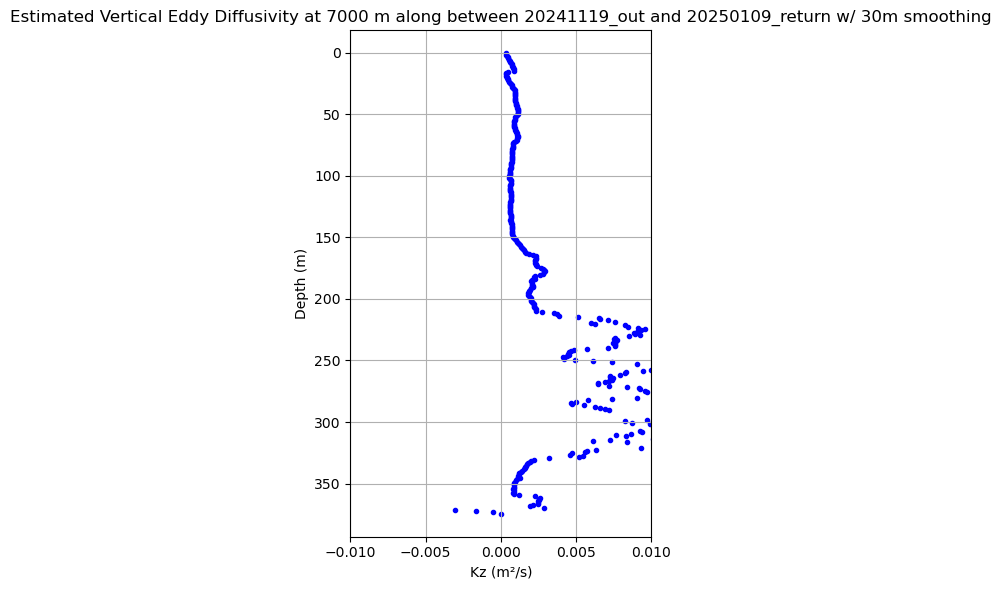

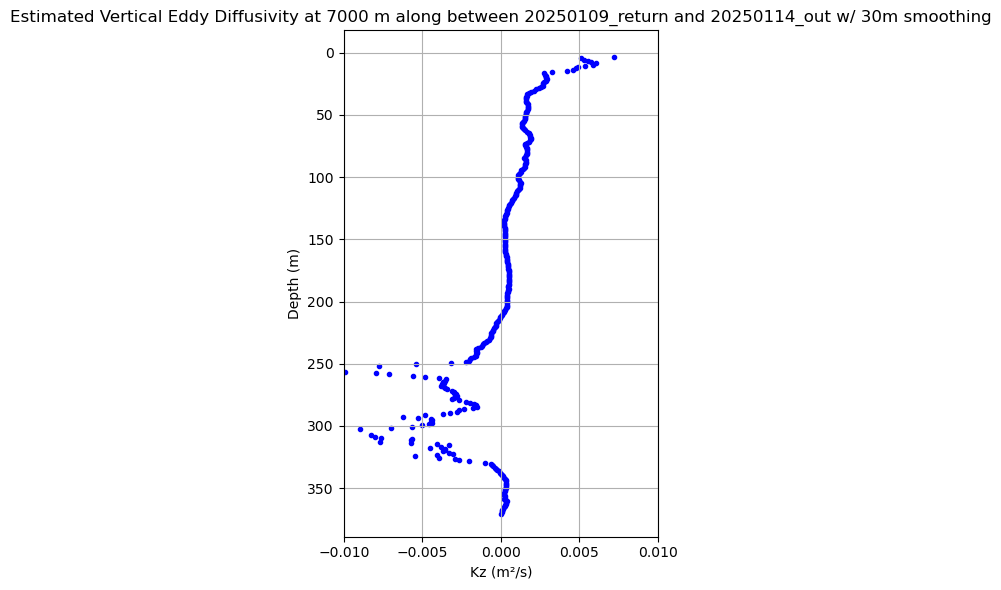

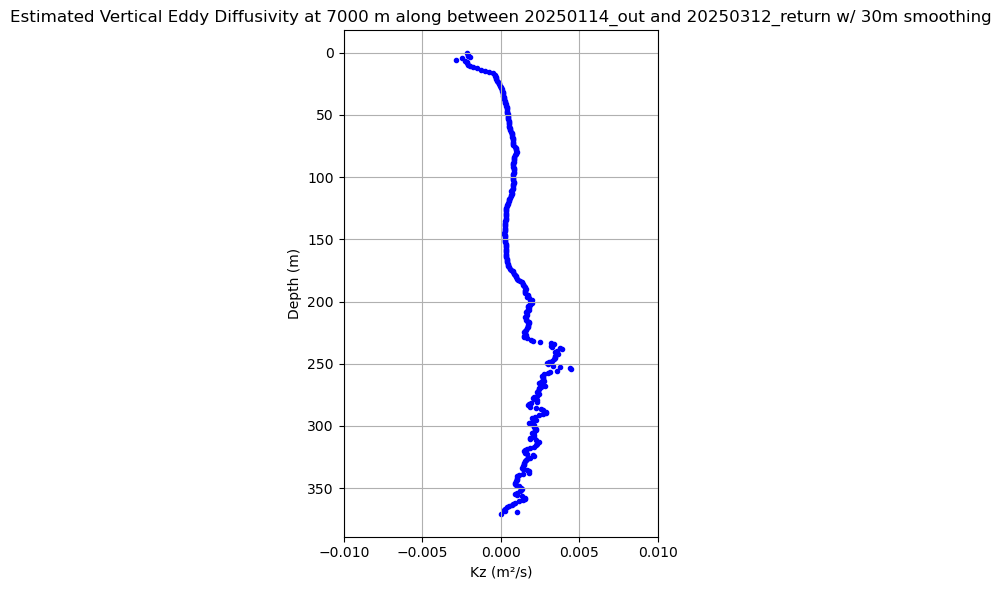

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt

# Example: load your cube
cube = xr.open_dataset(os.path.expanduser('~/Desktop/Summer 2025 Python/calvert_cube.nc'))

def estimate_Kz_from_density(cube, transect_label1, transect_label2, along_value=6500, depth_min=0, depth_max=420, smoothing_window=10, plot_density = False, xlim = (-0.02, 0.02)):

    """
    Estimate vertical eddy diffusivity Kz using the Manning et al. method (robust version).
    """

    # Extract depth
    depth = cube['depth'].values
    depth_mask = (depth >= depth_min) & (depth <= depth_max)
    depth_sel = depth[depth_mask]

    # Extract transects
    transect_da1 = cube['potential_density'].sel(transect=transect_label1)
    transect_da2 = cube['potential_density'].sel(transect=transect_label2)

    # Select along profiles
    profile_da1 = transect_da1.sel(along=along_value, method='nearest')
    profile_da2 = transect_da2.sel(along=along_value, method='nearest')

    # Convert to arrays
    pdens1 = profile_da1.values - 1000
    pdens2 = profile_da2.values - 1000

    # Subset depth
    pdens1 = pdens1[depth_mask]
    pdens2 = pdens2[depth_mask]

    # Identify depths with valid data in *both* profiles
    valid = ~np.isnan(pdens1) & ~np.isnan(pdens2)
    depth_sel = depth_sel[valid]
    pdens1 = pdens1[valid]
    pdens2 = pdens2[valid]

    print(f"After masking, {len(depth_sel)} valid depths remain.")

    if len(depth_sel) < 5:
        raise ValueError("Too few valid data points after masking NaNs.")

    # Time difference
    time1_val = cube["time"].sel(transect=transect_label1).sel(along=along_value, method="nearest").values
    time2_val = cube["time"].sel(transect=transect_label2).sel(along=along_value, method="nearest").values

    time1 = pd.to_datetime(str(time1_val))
    time2 = pd.to_datetime(str(time2_val))
    delta_t = (time2 - time1).total_seconds()
    print("delta_t (seconds):", delta_t)

    # ∂σ/∂t
    drho_dt = (pdens2 - pdens1) / delta_t

    # Smoothed mean profile
    pdens_mean = 0.5 * (pdens1 + pdens2)
    pdens_smooth = pdens_mean
    pdens_smooth = pd.Series(pdens_mean).rolling(window=smoothing_window, center=True, min_periods=1).mean().values

    # ∂σ/∂z
    drho_dz = np.gradient(pdens_smooth, depth_sel)

    # Initialize Kz
    Kz = np.full_like(depth_sel, np.nan)
    gradient = np.full_like(depth_sel, np.nan)

    # Compute Kz
    for i, z0 in enumerate(depth_sel):
        integral = np.trapezoid(drho_dt[i:][::-1], depth_sel[i:][::-1])
        gradient[i] = drho_dz[i]

        if np.abs(Kz[i]) < 1e-2:
            print(f"Depth {z0:.1f} m: integral={integral:.3e}, gradient={gradient:.3e}, Kz={Kz[i]:.3e}")
            
        gradient[i] = drho_dz[i]
        Kz[i] = integral / gradient[i]

        # For example:
    Kz = np.where((Kz > -1) & (Kz < 1), Kz, np.nan)
    if plot_density is True:

        plt.figure(figsize=(5,6))
        plt.plot(pdens1, depth_sel, label="Profile 1")
        plt.plot(pdens2, depth_sel, label="Profile 2")
        plt.plot(pdens_smooth, depth_sel, label="Potential Density (Smoothed)", linestyle='-', color='red')
        plt.gca().invert_yaxis()
        plt.xlabel("Sigma_theta (kg/m³)")
        plt.ylabel("Depth (m)")
        plt.legend()
        plt.grid()
        plt.title("Density Profiles")

        plt.figure(figsize=(5,6))
        plt.plot(drho_dt, depth_sel, label="∂ρ/∂t")
        plt.axvline(0, color='gray')
        plt.gca().invert_yaxis()
        plt.xlabel("∂ρ/∂t (kg/m³/s)")
        plt.ylabel("Depth (m)")
        plt.legend()
        plt.grid()

        plt.figure(figsize=(5,6))
        plt.plot(np.cumsum(drho_dt[::-1])[::-1], depth_sel, label="Cumulative Integral")
        plt.axvline(0, color='gray')
        plt.gca().invert_yaxis()
        plt.xlabel("Integral of ∂ρ/∂t")
        plt.ylabel("Depth (m)")
        plt.legend()
        plt.grid()

        plt.figure(figsize=(5,6))
        plt.scatter(gradient, depth_sel, label="drho_dz", marker = '.')
        plt.gca().invert_yaxis()
        plt.xlabel(r"Gradient ($ \frac {\frac{kg}{m^3}}{m} $)")
        plt.ylabel("Depth (m)")
        plt.legend()
        plt.grid()
        plt.xlim(xlim)

    plt.figure(figsize=(4,6))
    plt.scatter(Kz, depth_sel, marker=".", color = 'blue')
    plt.gca().invert_yaxis()
    plt.xlabel("Kz (m²/s)")
    plt.ylabel("Depth (m)")
    plt.grid()
    plt.title(f"Estimated Vertical Eddy Diffusivity at {along_value} m along between {transect_label1} and {transect_label2} w/ {smoothing_window}m smoothing")
    plt.tight_layout()
    plt.xlim(xlim)

    return depth_sel, Kz

depths, kz_estimates = estimate_Kz_from_density(
    cube,
    transect_label1= '20241114_return',
    transect_label2='20241119_out',
    along_value=7000,
    depth_min=0,
    depth_max=400, smoothing_window =  30, xlim = (-0.01, 0.01))

depths, kz_estimates = estimate_Kz_from_density(
    cube,
    transect_label1='20241119_out',
    transect_label2='20250109_return',
    along_value=7000,
    depth_min=0,
    depth_max=400, smoothing_window =  30, xlim = (-0.01, 0.01))

depths, kz_estimates = estimate_Kz_from_density(
    cube,
    transect_label1= '20250109_return',
    transect_label2='20250114_out',
    along_value=7000,
    depth_min=0,
    depth_max=400, smoothing_window =  30, plot_density= False, xlim = (-0.01, 0.01))

depths, kz_estimates = estimate_Kz_from_density(
    cube,
    transect_label1= '20250114_out',
    transect_label2='20250312_return',
    along_value=7000,
    depth_min=0,
    depth_max=400, smoothing_window =  30, xlim = (-0.01, 0.01))

After masking, 244 valid depths remain.
delta_t (seconds): 5454364.854721


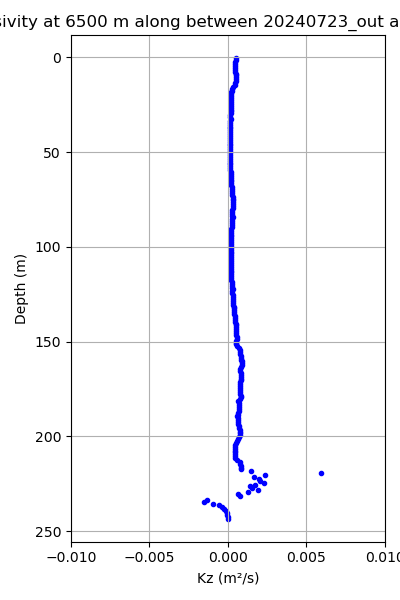

In [3]:
%matplotlib widget
depths, kz_estimates = estimate_Kz_from_density(
    cube,
    transect_label1= '20240723_out',
    transect_label2= '20240924_out',
    along_value=6500,
    depth_min=0,
    depth_max=400, smoothing_window =  30, xlim = (-0.01, 0.01))

In [4]:
# Extract transect labels
transect_labels = cube['transect'].values

# Find the indices
idx1 = np.where(transect_labels == '20241114_return')[0][0]
idx2 = np.where(transect_labels == '20241119_out')[0][0]

print(f"Index for 20241114_return: {idx1}")
print(f"Index for 20241119_out: {idx2}")

Index for 20241114_return: 54
Index for 20241119_out: 55


In [5]:
cube = xr.open_dataset(os.path.expanduser('~/Desktop/Summer 2025 Python/calvert_cube.nc'))
pdens_all = cube['potential_density'].values - 1000  # sigma_theta in kg/m3
transects = cube['transect'].values
transects

array(['20190615_out', '20190621_return', '20190623_return',
       '20200810_out', '20200902_return', '20200908_out',
       '20200930_return', '20201006_out', '20201028_return',
       '20201103_out', '20201126_return', '20210212_out',
       '20210310_return', '20210325_out', '20210408_return',
       '20210413_out', '20210505_return', '20210511_out',
       '20210603_return', '20210704_out', '20220608_out',
       '20220701_return', '20220707_out', '20220728_return',
       '20220914_out', '20221012_return', '20221018_out',
       '20221125_return', '20221129_out', '20230320_out',
       '20230413_return', '20230418_out', '20230512_return',
       '20230516_out', '20230519_out', '20230614_return', '20230620_out',
       '20230714_return', '20230720_out', '20230721_out',
       '20230809_return', '20230811_out', '20230911_return',
       '20230915_out', '20231013_return', '20231019_out', '20240312_out',
       '20240416_out', '20240510_return', '20240516_out',
       '20240717_retur

In [6]:
# transect, along, depth

In [7]:
(cube['time'].shape)

(62, 1602)


=== Processing: 20240312_out -> 20240416_out ===

After masking, 173 valid depths remain.
delta_t (seconds): 3013425.835562

=== Processing: 20240416_out -> 20240510_return ===

After masking, 173 valid depths remain.
delta_t (seconds): 1982849.711806

=== Processing: 20240510_return -> 20240516_out ===

After masking, 249 valid depths remain.
delta_t (seconds): 596604.291886

=== Processing: 20240516_out -> 20240717_return ===

After masking, 249 valid depths remain.
delta_t (seconds): 5313233.361913

=== Processing: 20240717_return -> 20240723_out ===

After masking, 244 valid depths remain.
delta_t (seconds): 584055.908385

=== Processing: 20240723_out -> 20240918_return ===

After masking, 0 valid depths remain.


ValueError: Too few valid data points after masking NaNs.

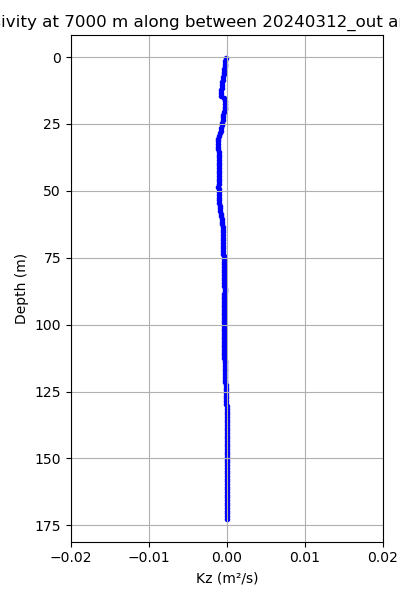

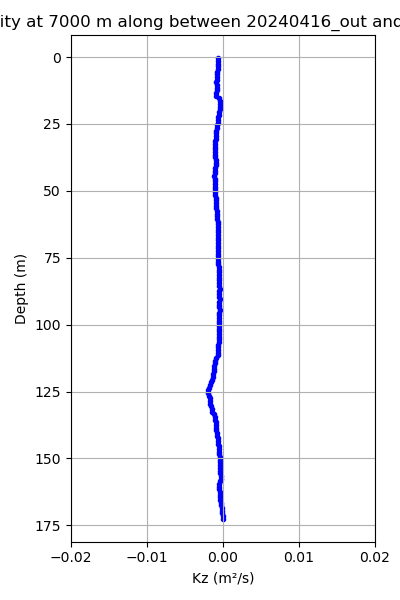

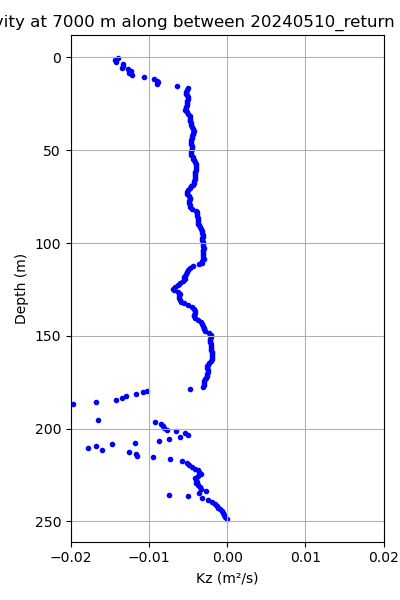

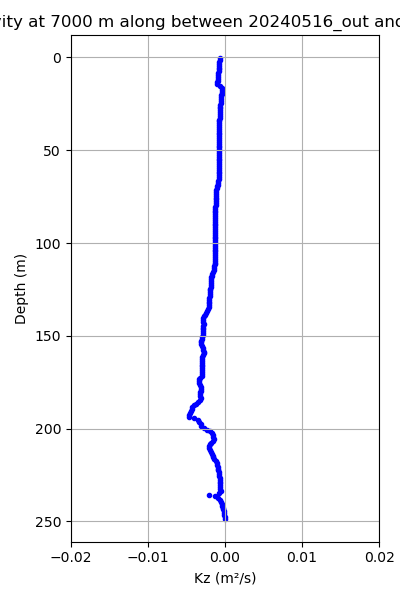

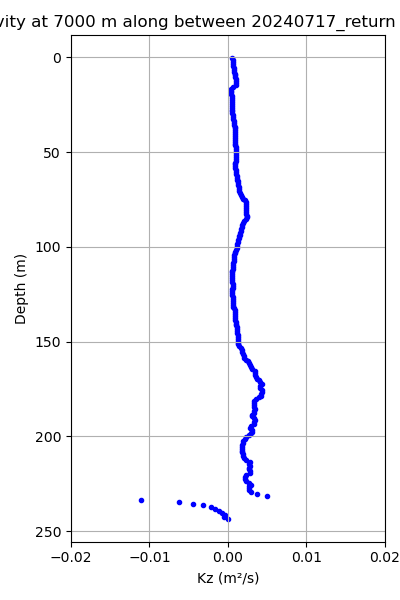

In [8]:
transects = [
    '20240312_out',
    '20240416_out',
    '20240510_return',
    '20240516_out',
    '20240717_return',
    '20240723_out',
    '20240918_return',
    '20240924_out',
    '20241114_return',
    '20241119_out',
    '20250109_return',
    '20250114_out',
    '20250312_return',
    '20250430_return',
    '20250506_out',
    '20250625_return'
]

results = {}

# Loop through pairs of transects
for i in range(len(transects)-1):
    t1 = transects[i]
    t2 = transects[i+1]

    print(f"\n=== Processing: {t1} -> {t2} ===\n")

    depths, kz_estimates = estimate_Kz_from_density(
        cube,
        transect_label1=t1,
        transect_label2=t2,
        along_value=7000,
        depth_min=0,
        depth_max=400,
        smoothing_window=30,
        plot_density=False  # or True if you want to see all the plots
    )

    # Save results in a dictionary keyed by the transect pair
    results[(t1, t2)] = (depths, kz_estimates)

print("\nAll transect pairs processed.")

# TRYING AGAIN #

/var/folders/w3/xmmx3z314913xcdb0jf7m8h40000gn/T/ipykernel_3571/2523633809.py:105: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


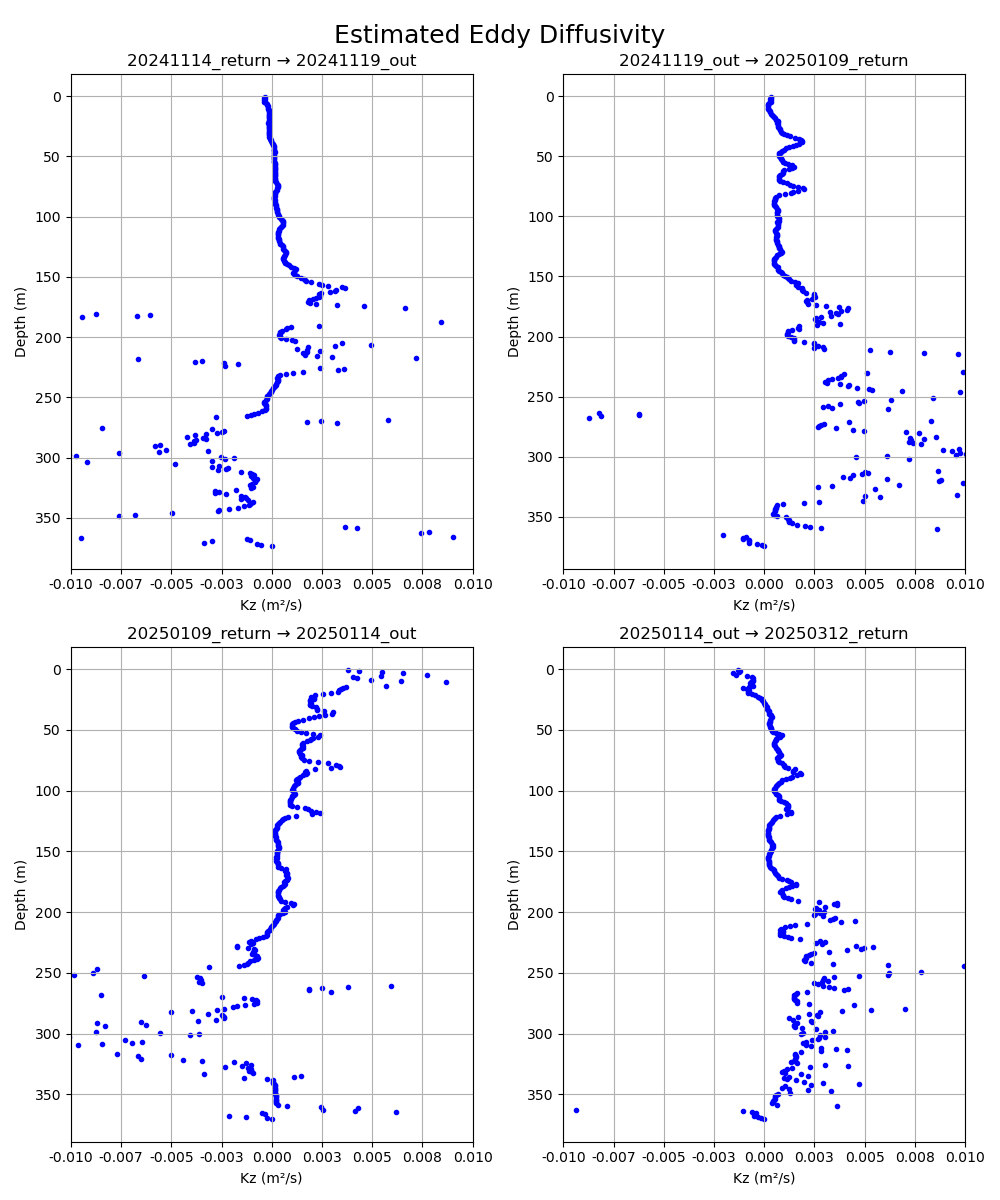

In [10]:
def estimate_Kz_and_plot_multiple(
    cube,
    transect_pairs,
    along_value=7000,
    depth_min=0,
    depth_max=400,
    smoothing_window=30,
    xlim=(-0.01, 0.01),
    n_columns=4
):
    """
    Estimate Kz for multiple transect pairs and plot them as subplots.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    results = []

    n = len(transect_pairs)
    n_rows = int(np.ceil(n / n_columns))

    fig, axes = plt.subplots(
        n_rows,
        n_columns,
        figsize=(n_columns * 5, n_rows * 6),
        constrained_layout=True
    )
    axes = axes.flatten()

    for i, (label1, label2) in enumerate(transect_pairs):
        ax = axes[i]

        # Extract depth
        depth = cube['depth'].values
        depth_mask = (depth >= depth_min) & (depth <= depth_max)
        depth_sel = depth[depth_mask]

        # Extract transects
        transect_da1 = cube['potential_density'].sel(transect=label1)
        transect_da2 = cube['potential_density'].sel(transect=label2)

        # Select along profiles
        profile_da1 = transect_da1.sel(along=along_value, method='nearest')
        profile_da2 = transect_da2.sel(along=along_value, method='nearest')

        pdens1 = profile_da1.values - 1000
        pdens2 = profile_da2.values - 1000

        pdens1 = pdens1[depth_mask]
        pdens2 = pdens2[depth_mask]

        valid = ~np.isnan(pdens1) & ~np.isnan(pdens2)
        depth_valid = depth_sel[valid]
        pdens1 = pdens1[valid]
        pdens2 = pdens2[valid]

        if len(depth_valid) < 5:
            print(f"Skipping {label1} to {label2}: not enough valid points.")
            ax.axis('off')
            continue

        # Time delta
        time1_val = cube["time"].sel(transect=label1).sel(along=along_value, method="nearest").values
        time2_val = cube["time"].sel(transect=label2).sel(along=along_value, method="nearest").values
        time1 = pd.to_datetime(str(time1_val))
        time2 = pd.to_datetime(str(time2_val))
        delta_t = (time2 - time1).total_seconds()

        drho_dt = (pdens2 - pdens1) / delta_t

        pdens_mean = 0.5 * (pdens1 + pdens2)
        pdens_smooth = pd.Series(pdens_mean).rolling(window=smoothing_window, center=True, min_periods=1).mean().values
        drho_dz = np.gradient(pdens_smooth, depth_valid)

        # Compute Kz
        Kz = np.full_like(depth_valid, np.nan)
        for j, z0 in enumerate(depth_valid):
            integral = np.trapezoid(drho_dt[j:][::-1], depth_valid[j:][::-1])
            Kz[j] = integral / drho_dz[j]

        # Clip outliers
        Kz = np.where((Kz > -1) & (Kz < 1), Kz, np.nan)

        # Plot
        ax.scatter(Kz, depth_valid, marker=".", color='blue')
        ax.invert_yaxis()
        ax.set_xlabel("Kz (m²/s)")
        ax.set_ylabel("Depth (m)")
        ax.set_xlim(xlim)
        ax.set_title(f"{label1} → {label2}")
        ax.tick_params(axis="x", rotation=0)
        from matplotlib.ticker import MultipleLocator, FormatStrFormatter
        ax.xaxis.set_major_formatter(FormatStrFormatter("%.3f"))
        

        ax.grid()
        results.append((depth_valid, Kz))

    # Turn off unused axes
    for j in range(n, len(axes)):
        axes[j].axis('off')

    plt.suptitle("Estimated Eddy Diffusivity", fontsize=18)
    plt.tight_layout()
    plt.show()

    return results

results = estimate_Kz_and_plot_multiple(
    cube,
    transect_pairs=[
        ('20241114_return', '20241119_out'),
        ('20241119_out', '20250109_return'),
        ('20250109_return', '20250114_out'),
        ('20250114_out', '20250312_return')
    ],
    along_value=7000,
    depth_min=0,
    depth_max=400,
    smoothing_window=10,
    xlim=(-0.01, 0.01),
    n_columns=2)